In [1]:
cd drive/MyDrive/skoltech/project_DL_part1/dataset  

/content/drive/MyDrive/skoltech/project_DL_part1/dataset


In [2]:
import math
import random
import os
import matplotlib.pyplot as plt
import PIL
from tqdm import tqdm
import torch
from torch import nn, autograd, optim, utils  
from torch.nn import functional as F
import torch.utils.data as data
from torchvision import transforms, utils, datasets, models
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.optim as optim
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import pandas as pd
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create Dataset and Dataloader

In [4]:
class custom_dataset(Dataset):
    def __init__(self, type_='train'):
        # load all nii handle in a list
        self.labels = []
        self.images_list = []
        
        df = pd.read_csv(type_ + '.csv')
        files = df['imagename']

        
        labels_dict = {'pneumonia':0, 'COVID-19':1, 'normal':2}
        # transform_test = transforms.Resize((512, 512))

        transform = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Grayscale(num_output_channels=1),
                              transforms.Resize((600,600)),
                              transforms.RandomAffine(degrees=5,translate=(0.1,0.1)),
                              transforms.CenterCrop((512, 512)),
                              transforms.ColorJitter(brightness=(0.9, 1.1)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,))
])

        for i, file in tqdm(enumerate(files)):
            if_exist = os.path.exists(type_ + '/' + file)
            if if_exist:
                image = Image.open(type_ + '/' + file)
                image = np.array(image)
            
                # if len(image.shape)==2:
                image = torch.tensor(image)
                if len(image.shape)>2:
                  if image.shape[0] != 3 and image.shape[0] != 1:
                    image = image.permute(2, 0, 1)
                else:
                    image.unsqueeze_(0)
                self.images_list.append(transform(image))
                self.labels.append(labels_dict[df['class'][i]])

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        image = self.images_list[idx]
        target = self.labels[idx]        
        return image, target

In [5]:
# train_dataset = custom_dataset('train')
test_dataset = custom_dataset('test')
# val_dataset = custom_dataset('val')

2306it [00:42, 54.13it/s]


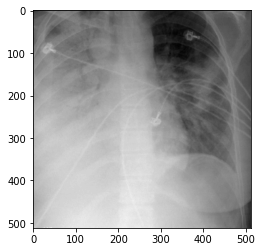

In [6]:
img, label = test_dataset.__getitem__(3)
plt.imshow(img[0], cmap='gray')
plt.show()

In [7]:
dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# Load pretrained classifier model

In [8]:
def load_classifier_model(weights='modelbest.pth'):
  model = models.densenet161(pretrained=True)
  model.features.conv0 = nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  model.classifier = nn.Linear(in_features=2208, out_features=3, bias=True)
  model.load_state_dict(torch.load(weights))
  model.to(device)
  return model

classifier = load_classifier_model()
classifier.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [9]:
acc = []
predicted = []
true = []
n_samples = 0
for i, data in tqdm(enumerate(dataloader, 0)):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    pred_labels = torch.argmax(classifier(inputs.float()), dim=1)
    predicted += pred_labels.tolist()
    true += labels.tolist()
    acc.append((pred_labels == labels).sum())
    n_samples += inputs.shape[0]
print()
print('Final accuracy is {}'.format(np.sum(acc).item()/n_samples))

314it [00:18, 16.93it/s]

KeyboardInterrupt: ignored

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import  confusion_matrix

cm = confusion_matrix(true, predicted)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal','Covid-19', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal','Covid-19', 'Pneumonia']);

# Define losses for VAE

In [8]:
l1_loss = nn.L1Loss()   

def get_output():
    def hook(classifier, input, output):
        classifier.output = output
    return hook

layers = [classifier.features.denseblock3.denselayer1.conv1,
          classifier.features.denseblock4.denselayer1.conv1,
          classifier.features.denseblock2.denselayer1.conv1,
          classifier.features.denseblock1.denselayer1.conv1, 
          ]

for i in layers:
    i.register_forward_hook(get_output())  

def perceptual_loss(img, recon):
    with torch.no_grad():
        img_out = classifier(img)
    features_img = []
    for i in layers:
        features_img.append(i.output)
        
    recon_out = classifier(recon)
    features_recon = []
    for i in layers:
        features_recon.append(i.output)
    
    loss = 0.0
    for j in range(len(layers)):
        loss += l1_loss(features_recon[j], features_img[j])      
    return loss

def kld_loss(mu, logvar):
    return (-0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()))

def criterion(img_batch, recon, mu, logvar):
    return l1_loss(recon, img_batch), kld_loss(mu, logvar), l1_loss(recon, img_batch) + kld_loss(mu, logvar) #+ perceptual_loss(img_batch, recon)

# Define model's architecture

In [6]:
from models import VAE_upsample
from models import VAE_conv

In [9]:
import torchsummary
model = VAE_conv()
summary(model.to(device), (1, 512, 512 ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             144
       BatchNorm2d-2         [-1, 16, 256, 256]              32
         LeakyReLU-3         [-1, 16, 256, 256]               0
              Conv-4         [-1, 16, 256, 256]               0
            Conv2d-5         [-1, 32, 256, 256]           4,608
       BatchNorm2d-6         [-1, 32, 256, 256]              64
         LeakyReLU-7         [-1, 32, 256, 256]               0
              Conv-8         [-1, 32, 256, 256]               0
            Conv2d-9         [-1, 32, 128, 128]           9,216
      BatchNorm2d-10         [-1, 32, 128, 128]              64
        LeakyReLU-11         [-1, 32, 128, 128]               0
             Conv-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 32, 128, 128]           9,216
      BatchNorm2d-14         [-1, 32, 1

# Train model

In [11]:
def train(model, optimizer, n_epochs=10, writer_path='./runs_10', save=True, model_path='model'):

  epoch_loss = []
  writer = SummaryWriter(writer_path)

  for epoch in tqdm(range(n_epochs)):
    samples = 0
    running_loss = 0
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, mean, std = model(inputs.float())
        # print(outputs.shape, inputs.shape)
        samples += outputs.shape[0]
        l1_loss, kl_loss, loss = criterion(inputs.float(), outputs.float(),  mean, std)
        running_loss += loss.item() * outputs.shape[0]
        # print(loss)
        loss.backward()
        optimizer.step()
        writer.add_scalar("Loss/loss", loss, len(dataloader) * epoch + i)
        writer.add_scalar("Loss/l1_loss", l1_loss, len(dataloader) * epoch + i)
        writer.add_scalar("Loss/kl_loss", kl_loss, len(dataloader) * epoch + i)
    epoch_loss.append(running_loss / samples)
    print('Epoch loss is', epoch_loss[-1])
    torch.save(model.state_dict(), model_path + 'final_night_model_epoch_{}_512_size'.format(epoch))
    img_grid_out = torchvision.utils.make_grid(outputs[0, 0, ...].detach(), normalize=True)
    img_grid_in = torchvision.utils.make_grid(inputs[0, 0, ...].detach(), normalize=True)
    writer.add_image('input', img_grid_out, epoch)
    writer.add_image('output', img_grid_in, epoch)
  writer.close()
  return model

In [9]:
EVAL = True
use_upsample = True
PRETRAIN = True

path_perceptual = './important_checkpoints/vae_perceptual_loss_and_upsampling'
path_upconv  = './important_checkpoints/vae_upconv'

if use_upsample:
  model = VAE_upsample().to(device)
  if PRETRAIN:
    model.load_state_dict(torch.load(path_perceptual))
else:
  model = VAE_conv().to(device)
  if PRETRAIN:
    model.load_state_dict(torch.load(path_upconv))

# Choose model
if EVAL:  
  model.eval()

optimizer = optim.Adam(model.parameters(), lr=0.0004)
# model = train(model, optimizer, n_epochs=500)

EVAL mode


# Tensorboard visualization

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./runs_10

## Check performance on Test data

In [13]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

resize = transforms.Resize((128,128))

def collect(model, VIZUALIZE=False):
  samples = 0
  running_loss = 0
  psnrs = []
  ssims=[]
  l1_losses = []
  for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs, mean, std = model(inputs.float())
      if VISUALIZE:
        plt.title('Target')
        plt.imshow(resize(inputs)[0, 0,...].detach().cpu().numpy(), cmap='gray')
        plt.show()
        plt.title('Resconstructed')
        plt.imshow(resize(outputs)[0, 0,...].detach().cpu().numpy(), cmap='gray')
        plt.show()
      for i in range(inputs.shape[0]):
        psnrs.append(psnr(inputs[i, 0, ...].detach().cpu().numpy(), outputs[i, 0, ...].detach().cpu().numpy()))
        ssims.append(ssim(inputs[i, 0, ...].detach().cpu().numpy(), outputs[i, 0, ...].detach().cpu().numpy()))
      samples += outputs.shape[0]
      l1, kl, loss = criterion(inputs.float(), outputs.float(),  mean, std)
      running_loss += loss * outputs.shape[0]
      l1_losses.append(l1.item())
      print(running_loss/samples, np.mean(psnrs), np.mean(ssims), np.mean(l1_losses))
  return running_loss, samples, psnrs, ssims, l1

In [ ]:
running_loss, samples, psnrs, ssims, l1 = collect(model)

## Creating synthetic dataset $(w_i, G(w_i))$

In [38]:
def create_synthetic_dataset(model, dataloader, n_samples=2000):  
    G_w = []
    w = []
    l = []

    samples = 0
    while samples < n_samples:
      for i, data in tqdm(enumerate(dataloader, 0)):
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs, mean, std = model(inputs.float())
          samples += inputs.shape[0]
          latent_vec = model.reparameterize(mean, std)
          l.append(labels.detach().cpu().numpy())
          w.append(latent_vec.detach().cpu().numpy())
          G_w.append(outputs.detach().cpu().numpy())

    np.save('latent_data.npy', np.concatenate(w))   
    np.save('generated_data.npy', np.concatenate(G_w)) 
    np.save('generated_labels.npy', np.concatenate(l)) 
    return np.concatenate(w), np.concatenate(G_w), np.concatenate(l)

In [39]:
GENERATE = False

if GENERATE:
  w, G_w, l = create_synthetic_dataset(model, dataloader)


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)

5it [00:00, 47.61it/s]
10it [00:00, 47.04it/s]
15it [00:00, 47.35it/s]
20it [00:00, 47.67it/s]
25it [00:00, 48.08it/s]
30it [00:00, 48.48it/s]
35it [00:00, 48.51it/s]
40it [00:00, 48.55it/s]
45it [00:00, 48.50it/s]
50it [00:01, 48.59it/s]
55it [00:01, 48.71it/s]
60it [00:01, 48.43it/s]
65it [00:01, 48.53it/s]
70it [00:01, 48.63it/s]
75it [00:01, 48.57it/s]
80it [00:01, 48.68it/s]
85it [00:01, 48.80it/s]
90it [00:01, 48.88it/s]
95it [00:01, 48.87it/s]
100it [00:02, 48.73it/s]
105it [00:02, 48.71it/s]
110it [00:02, 48.61it/s]
115it [00:02, 48.73it/s]
120it [00:02, 48.66it/s]
125it [00:02, 48.50it/s]
130it [00:02, 48.

# Upload synthetic data

In [4]:
latent_data = np.load('./important_checkpoints/latent_data.npy', allow_pickle=True)
generated = np.load('./important_checkpoints/generated_data.npy', allow_pickle=True)
generated_labels = np.load('./important_checkpoints/generated_labels.npy', allow_pickle=True)

print(latent_data.shape, generated.shape, generated_labels.shape)

(2222, 512, 9, 9) (2222, 1, 512, 512) (2222,)


# ResNet50 Encoder on $(w_{i}, G(w_{i}))$

In [5]:
class Fake_Data(Dataset):
    def __init__(self, X, y, l):
        super(Fake_Data, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.labels = torch.tensor(l, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.labels[idx]

In [6]:
train_dset = Fake_Data(generated, latent_data, generated_labels)
train_loader = DataLoader(train_dset, batch_size=16, shuffle=True)

In [7]:
from models import ResNet50_encoder

encoder = ResNet50_encoder()
encoder.to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [9]:
def train_encoder(encoder, criterion, opt, train_loader, scheduler=None, n_epochs=50):

  for epoch in range(n_epochs):
    
    encoder.train()
    losses_train = []
    losses_val = []

    for X, latent_repr, _ in train_loader:
      X, latent_repr = X.to(device), latent_repr.to(device)

      optimizer.zero_grad()
      output = encoder(X)
      loss = criterion(latent_repr, output)
      losses_train.append(loss.detach().cpu().numpy())

      loss.backward()
      optimizer.step()

    if scheduler is not None:
      scheduler.step()

    if epoch % 1 == 0:
      # mean_val = sum(losses_val)/len(losses_val)
      mean_train = sum(losses_train)/len(losses_train)

      print('Epoch {}/{} || Loss:  Train {:.4f}'\
                  .format(epoch, n_epochs, mean_train))
  return encoder

In [10]:
encoder = train_encoder(encoder, criterion, optimizer, train_loader)

Epoch 0/50 || Loss:  Train 1.0021
Epoch 1/50 || Loss:  Train 1.0003
Epoch 2/50 || Loss:  Train 0.9998
Epoch 3/50 || Loss:  Train 0.9993
Epoch 4/50 || Loss:  Train 0.9991
Epoch 5/50 || Loss:  Train 0.9988
Epoch 6/50 || Loss:  Train 0.9986
Epoch 7/50 || Loss:  Train 0.9984
Epoch 8/50 || Loss:  Train 0.9983
Epoch 9/50 || Loss:  Train 0.9981
Epoch 10/50 || Loss:  Train 0.9980
Epoch 11/50 || Loss:  Train 0.9978
Epoch 12/50 || Loss:  Train 0.9977
Epoch 13/50 || Loss:  Train 0.9975
Epoch 14/50 || Loss:  Train 0.9973
Epoch 15/50 || Loss:  Train 0.9971
Epoch 16/50 || Loss:  Train 0.9969
Epoch 17/50 || Loss:  Train 0.9967
Epoch 18/50 || Loss:  Train 0.9966
Epoch 19/50 || Loss:  Train 0.9963
Epoch 20/50 || Loss:  Train 0.9961
Epoch 21/50 || Loss:  Train 0.9958
Epoch 22/50 || Loss:  Train 0.9956
Epoch 23/50 || Loss:  Train 0.9953
Epoch 24/50 || Loss:  Train 0.9950
Epoch 25/50 || Loss:  Train 0.9947
Epoch 26/50 || Loss:  Train 0.9944
Epoch 27/50 || Loss:  Train 0.9940
Epoch 28/50 || Loss:  Train 0.

In [11]:
torch.save(encoder.state_dict(), './important_checkpoints/encoder_checkpoint.pth')